In [1]:
import sys
import os
import time
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm


# plotting imports
import matplotlib.pyplot as plt

# ml imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

# random forest
from sklearn.ensemble import RandomForestClassifier
# k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

# metric imports

# cnn imports
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.transforms import ToTensor

# our model imports
sys.path.append('../')
from model import model3

# Load Data

In [2]:
# load cancer dataset from sklearn
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

# split data
test_size = 0.2
train_size = 1 - test_size
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# set max cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("X shape: ", X_train.shape)
print("y shape: ", y_train.shape)

# remember to do any preprocessing necessary for the data

X shape:  (455, 30)
y shape:  (455,)


## Global Variables

In [4]:
# customize based on training data
dataset_name = "cancer"
data_sizes = [20, 50, 100, 200, 455]

# you shouldn't need to change these
benchmarking = {}
repeat = 5
info_length = 3     # train_acc, test_acc, time
date_format = "%y%m%d@%H%M"
datetime = dt.datetime.now().strftime(date_format)
replace_old_data = True

## Helper functions

In [5]:
def get_last_file(dir:str, partial_name:str):
    """
    Get the last file in a directory matching the partial name

    Parameters:
    partial_name (str): partial name of the file
    dir (str): directory to search in

    Returns:
    str: path to the last file
    """
    # get all the datetimes
    datetimes = [name.split("_")[-1].split(".")[0][1:] for name in os.listdir(dir) if partial_name in name]
    
    # get the latest datetime by converting to datetime object
    vals = [dt.datetime.strptime(date, date_format) for date in datetimes]
    if len(vals) == 0:
        return None
    
    # get the latest datetime and return the path
    latest_datetime = max(vals).strftime(date_format)
    return os.path.join(dir, f"{partial_name}_d{latest_datetime}.npy")


def build_dir(model_name:str):
    """
    Build the directory to save the numpy files
    Parameters:
        model_name (str): name of the model
    Returns:
        str: directory
    """
    return f"results/{dataset_name}/{model_name}/npy_files"


def build_name(val:bool, info_type:str, iteration):
    """
    Build the name of the numpy file
    Parameters:
        val (bool): whether the data is validation data
        info_type (str): type of information
        iteration (int): iteration number
    Returns:
        str: name of the numpy file
    """
    train = "train" if not val else "val"
    return f"{train}_{info_type}_i{iteration}"


def load_data(model_name:str, info_type:str, iteration, val=False):
    """
    Load the data from the most recent numpy file matching the partial name
    Parameters:
        model_name (str): name of the model
        info_type (str): type of information
        iteration (int): iteration number
        val (bool): whether the data is validation data
    Returns:
        np.ndarray: data from the numpy file or None if the file does not exist
    """
    dir = build_dir(model_name)
    partial_name = build_name(val, info_type, iteration)
    try:
        return np.load(get_last_file(dir, partial_name))
    except:
        print("Error: file not found")
        return None
    

def save_data(data:np.ndarray, model_name:str, info_type:str, iteration, 
              val=False, refresh=False):
    """
    Save the data to a numpy file
    Parameters:
        data (np.ndarray): data to save
        model_name (str): name of the model
        info_type (str): type of information
        iteration (int): iteration number
        val (bool): whether the data is validation data
        refresh (bool): whether to refresh the last file
    Returns: None
    """
    dir = build_dir(model_name)
    partial_name = build_name(val, info_type, iteration)
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Made a new directory", dir)
    
    # check if the directory has files
    if len(os.listdir(dir)) < info_length * repeat:
        refresh = False

    # remove the last file with the same partial name
    if refresh:
        last_file = get_last_file(dir, partial_name)
        if last_file is not None:
            os.remove(last_file)

    path = f"results/{dataset_name}/{model_name}/npy_files/{partial_name}_d{datetime}.npy"
    np.save(path, data)
    return None

# Model Training

In [6]:
def benchmark_ml(model_name, save_all=True):
    """
    Trains a model on the cancer dataset with different data sizes and saves the accuracy and time data.

    Parameters:
    model_name (str): The name of the model to train. Can be "randomforest", "knn", or "ours".
    save_all (bool): Whether to save all the data or just the means and stds

    Returns:
    results_dict (dict): A dictionary containing the accuracy and time data for each model and iteration
    """
    global data_sizes
    model = RandomForestClassifier(n_jobs=-1) if model_name == "randomforest" else \
            KNeighborsClassifier(n_jobs=-1) if model_name == "knn" else \
            model3() if model_name == "ours" else None
    results_dict = {model_name: {}}
    
    progressB = tqdm(total=repeat*len(data_sizes), desc=f"Benchmarking {model_name}")
    for i in range(repeat):
        time_list = []
        train_acc = []
        val_acc = []

        for size in data_sizes:
            if size is None or size > len(X_train):
                data_sizes[data_sizes.index(size)] = len(X_train)
                size = len(X_train)
            # train model
            clf = model
            start_time = time.perf_counter()
            clf.fit(X_train[:size], y_train[:size])
            end_time = time.perf_counter()
            y_pred = clf.predict(X_test)

            # predict and compute accuracy
            y_pred_train = clf.predict(X_train[:size])
            y_pred = clf.predict(X_test)
            acc_train = accuracy_score(y_train[:size], y_pred_train)
            acc_test = accuracy_score(y_test, y_pred)

            # update lists
            time_list.append(end_time - start_time)
            train_acc.append(acc_train)
            val_acc.append(acc_test)
            progressB.update(1)

        # Done training, now saving data
        train_acc = np.array(train_acc)
        val_acc = np.array(val_acc)
        time_list = np.array(time_list)
        if save_all:
            save_data(train_acc, model_name, "acc", i, refresh=replace_old_data)
            save_data(val_acc, model_name, "acc", i, val=True, refresh=replace_old_data)
            save_data(time_list, model_name, "time", i, refresh=replace_old_data)
        results_dict[model_name][i] = {"train_acc": train_acc, "val_acc": val_acc, "time": time_list}
    progressB.close()


    # Done benchmarking, calculate means and stds and saving them
    train_accs = np.array([results_dict[model_name][i]["train_acc"] for i in range(repeat)])
    val_accs = np.array([results_dict[model_name][i]["val_acc"] for i in range(repeat)])
    times = np.array([results_dict[model_name][i]["time"] for i in range(repeat)])
    train_acc_mean = np.mean(train_accs, axis=0)
    val_acc_mean = np.mean(val_accs, axis=0)
    time_mean = np.mean(times, axis=0)
    train_acc_std = np.std(train_accs, axis=0)
    val_acc_std = np.std(val_accs, axis=0)
    time_std = np.std(times, axis=0)

    # save means and stds
    save_data(train_acc_mean, model_name, "acc", "mean", refresh=True)
    save_data(val_acc_mean, model_name, "acc", "mean", val=True, refresh=True)
    save_data(time_mean, model_name, "time", "mean", refresh=True)
    save_data(train_acc_std, model_name, "acc", "std", refresh=True)
    save_data(val_acc_std, model_name, "acc", "std", val=True, refresh=True)
    save_data(time_std, model_name, "time", "std", refresh=True)
    results_dict[model_name]["mean"] = {"train_acc": train_acc_mean, "val_acc": val_acc_mean, "time": time_mean}
    results_dict[model_name]["std"] = {"train_acc": train_acc_std, "val_acc": val_acc_std, "time": time_std}
    
    return results_dict

In [7]:
# RANDOM FOREST
new_set = False
if new_set:
    datetime = dt.datetime.now().strftime(date_format)
model_name = 'randomforest'

rfr_results = benchmark_ml(model_name)
benchmarking.update(rfr_results)

Benchmarking randomforest: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


In [8]:
# K NEAREST NEIGHBORS
new_set = False
if new_set:
    datetime = dt.datetime.now().strftime(date_format)
model_name = 'knn'

knn_results = benchmark_ml(model_name)
benchmarking.update(knn_results)

Benchmarking knn: 100%|██████████| 25/25 [00:00<00:00, 52.63it/s]


In [9]:
# CONVOLUTIONAL NEURAL NETWORK
new_set = False
if new_set:
    datetime = dt.datetime.now().strftime(date_format)
model_name = 'cnn'

In [10]:
# METRIC LEARNING
new_set = False
if new_set:
    datetime = dt.datetime.now().strftime(date_format)
model_name = 'metric'

In [11]:
# OUR MODEL
new_set = False
if new_set:
    datetime = dt.datetime.now().strftime(date_format)
model_name = 'ours'

our_results = benchmark_ml(model_name)
benchmarking.update(our_results)

Benchmarking ours: 100%|██████████| 25/25 [2:09:26<00:00, 310.65s/it]  


# Model Evaluation

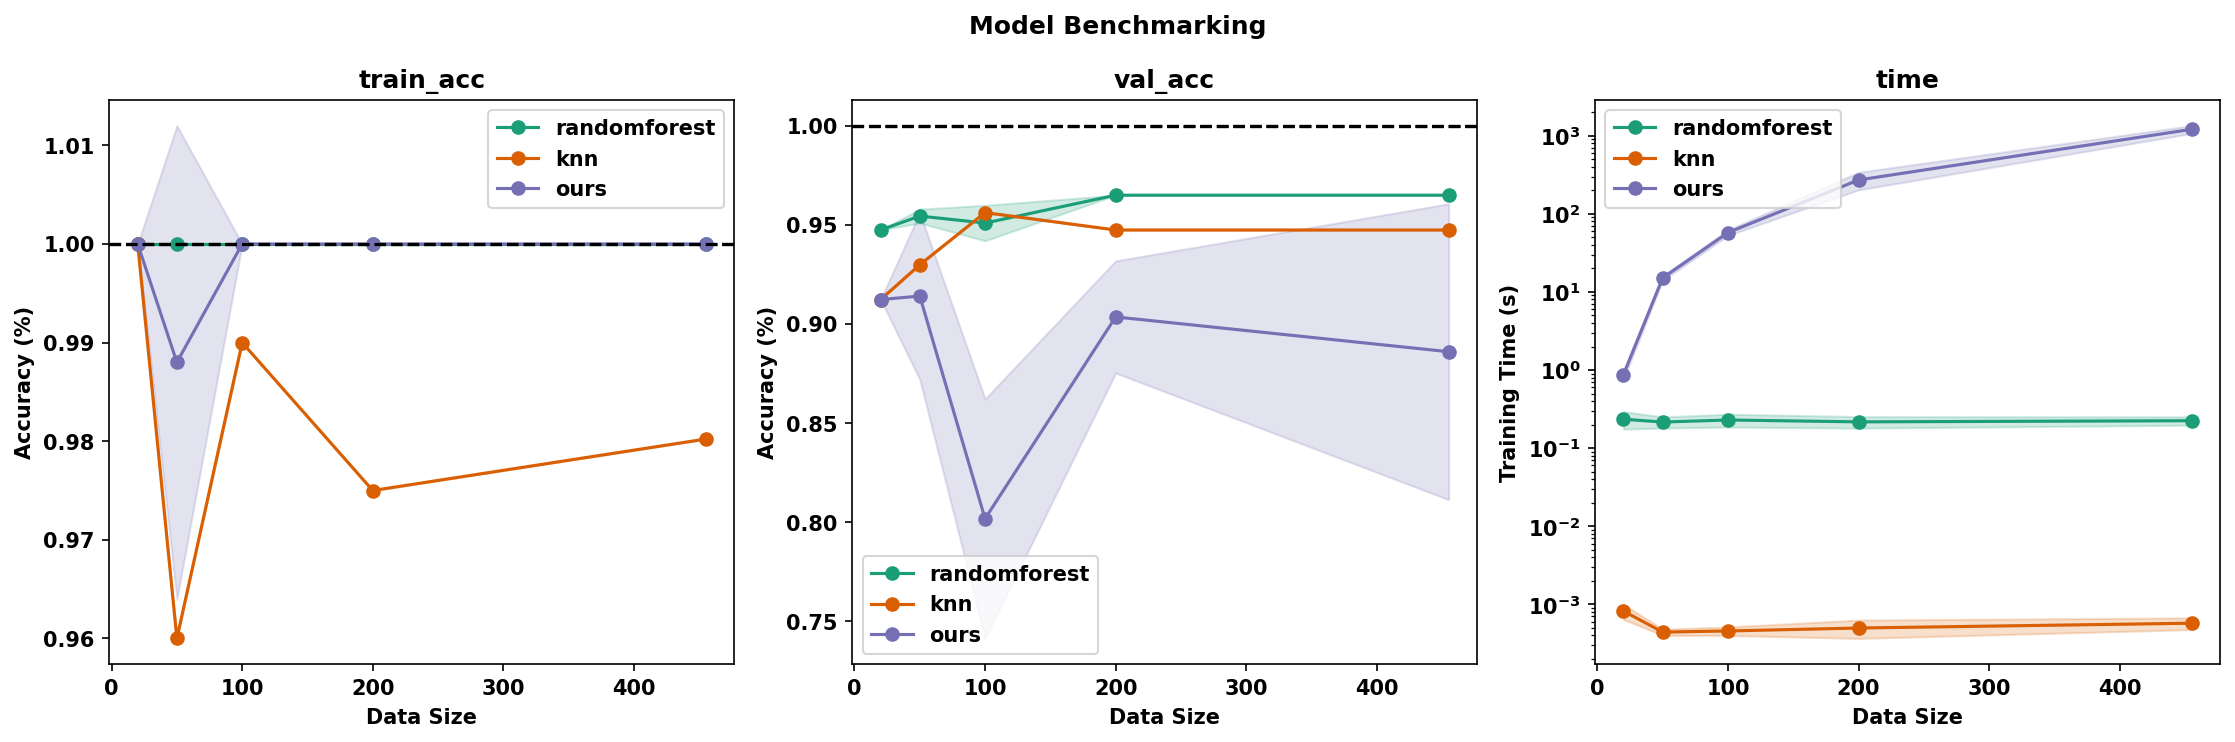

In [14]:
info_ylabels = ["Accuracy (%)", "Accuracy (%)", "Training Time (s)"]
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']

scale = 5
plt.figure(figsize=(scale*info_length, scale), dpi=150)
for j, (model_name, model_results) in enumerate(benchmarking.items()):
    for i, (info_type, means), (info_type2, stds) in zip(range(info_length), model_results["mean"].items(), model_results["std"].items()):
        plt.subplot(1, info_length, i+1)
        plt.plot(data_sizes, means, label=model_name, marker='o', color=colors[j])
        plt.fill_between(data_sizes, means - stds, means + stds, alpha=0.2, color=colors[j])
        plt.xlabel("Data Size")
        plt.ylabel(info_ylabels[i])
        if "acc" in info_type:
            plt.axhline(y=1, color='k', linestyle='--')
        if "time" in info_type:
            plt.yscale('log')
        plt.title(info_type)
        plt.legend()
plt.suptitle("Model Benchmarking")
plt.tight_layout()
plt.savefig(f"results/{dataset_name}/charts/benchmarking_{datetime}.png")

In [13]:
# pretty print the benchmarking results
for model_name, model_results in benchmarking.items():
    print(f"Model: {model_name}")
    for iteration, iteration_results in model_results.items():
        print(f"Iteration: {iteration}")
        for info_type, info in iteration_results.items():
            print(f"{info_type}: {info}")
    print()

Model: randomforest
Iteration: 0
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.95614035 0.96491228 0.96491228 0.96491228]
time: [0.3428083 0.2527884 0.2078108 0.1997685 0.1896407]
Iteration: 1
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.95614035 0.93859649 0.96491228 0.96491228]
time: [0.1659821 0.1699015 0.1722464 0.1823499 0.2254847]
Iteration: 2
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.95614035 0.94736842 0.96491228 0.96491228]
time: [0.203442  0.1919836 0.2118895 0.2203438 0.2373175]
Iteration: 3
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.94736842 0.94736842 0.96491228 0.96491228]
time: [0.2328407 0.2606556 0.2951357 0.2859293 0.2681744]
Iteration: 4
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.95614035 0.95614035 0.96491228 0.96491228]
time: [0.2276029 0.2042057 0.2590393 0.1963447 0.2010739]
Iteration: mean
train_acc: [1. 1. 1. 1. 1.]
val_acc: [0.94736842 0.95438596 0.95087719 0.96491228 0.96491228]
time: [0.2345352  0.21590696 0.22922434 0.216